# Training

## Imports

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages/")
sys.path.append("../")

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader

%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import os
import snook.data as sd
import snook.model as sm
import torch
import torch.nn as nn

## Data Loaders

In [2]:
train        = sd.ClDataset("dataset/train/renders", "dataset/train/data")
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

valid        = sd.ClDataset("dataset/valid/renders", "dataset/valid/data")
valid_loader = DataLoader(valid, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test         = sd.ClDataset("dataset/test/renders", "dataset/test/data")
test_loader  = DataLoader(test, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

## Model Training

In [3]:
layers    = [
    sm.Layer(  3,  16, 3),
    sm.Layer( 16,  32, 3),
    sm.Layer( 32,  64, 3),
    sm.Layer( 64, 128, 3),
    sm.Layer(128, 256, 3),
]
model     = sm.Classifier(layers, hidden=512, n_class=len(sd.COLORS) + 1, scale=0.4).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optim     = AdamW(model.parameters())

In [4]:
def softmax(x: np.ndarray) -> np.ndarray:
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def plot_example(name: str, dataset: sd.ReMaHeDataset) -> None:
    fig = plt.figure(figsize=(8, 12))
    
    for i in range(10):
        window, label = dataset[i]
        logits = softmax(model(window.unsqueeze(0).cuda())[0].cpu().numpy())
        ax1, ax2 = fig.add_subplot(10, 2, 2 * i + 1), fig.add_subplot(10, 2, 2 * i + 2)
        
        ax1.imshow(window.permute((1, 2, 0)).numpy())
        ax1.set_axis_off()
        ax2.bar(range(len(sd.COLORS) + 1), logits, tick_label=sd.COLORS + ["cue"])
        ax2.set_ylim(0, 1)
        if i != 9: ax2.set_xticks([], [])
        
    fig.canvas.draw()
    fig.savefig(f"{name}.png")
    fig.show()

<IPython.core.display.Javascript object>


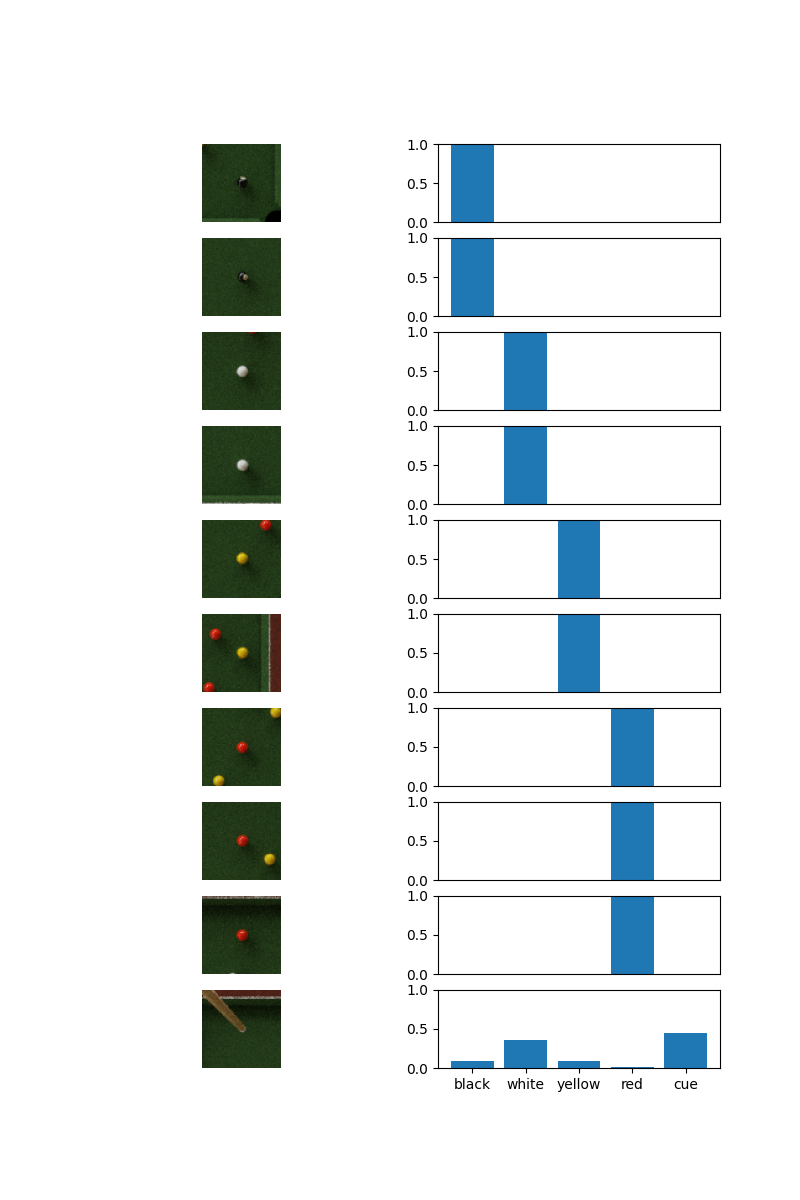

<ipython-input-4-41babbb99913>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if i != 9: ax2.set_xticks([], [])


<IPython.core.display.Javascript object>


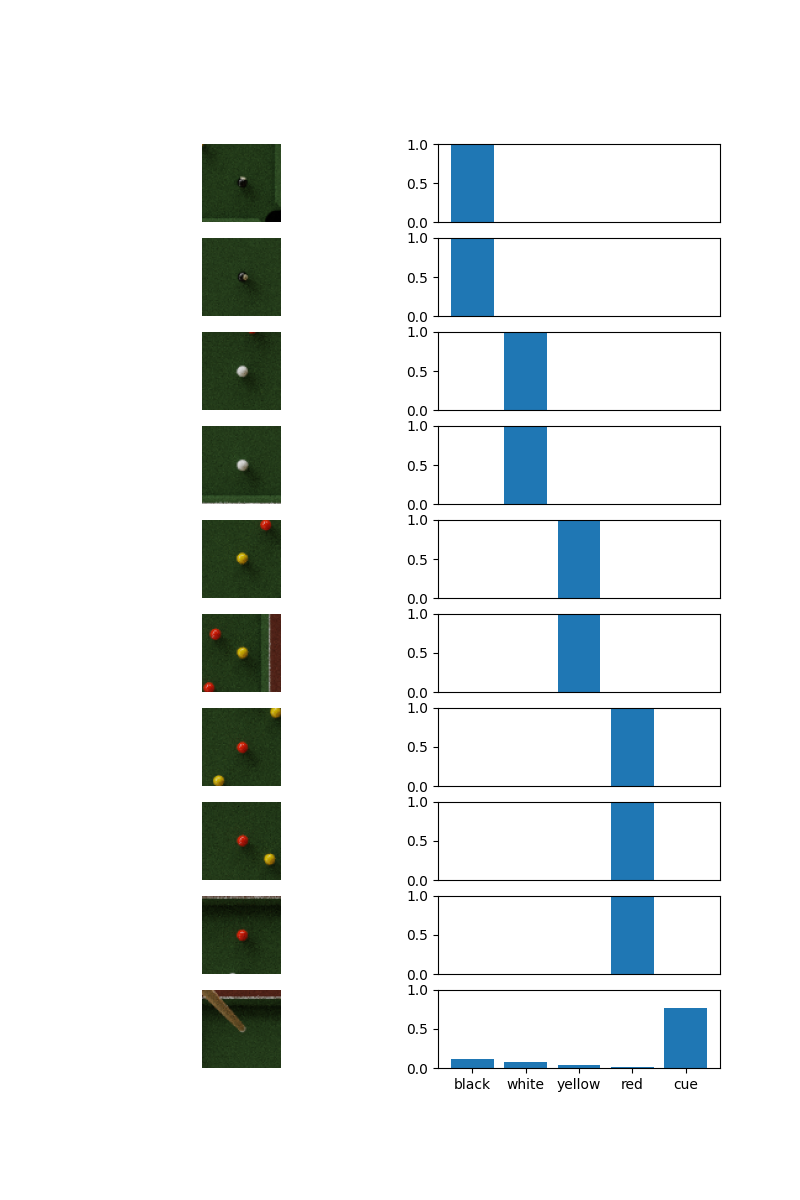

<IPython.core.display.Javascript object>


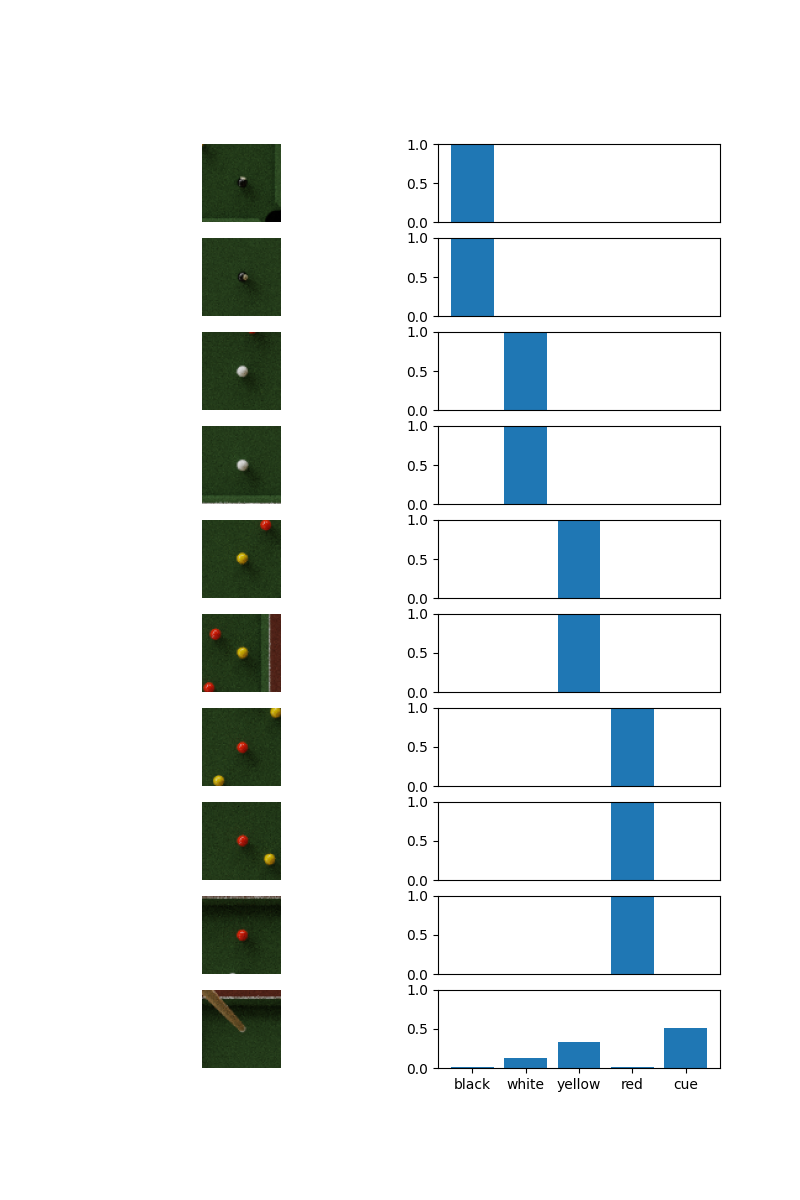

<IPython.core.display.Javascript object>


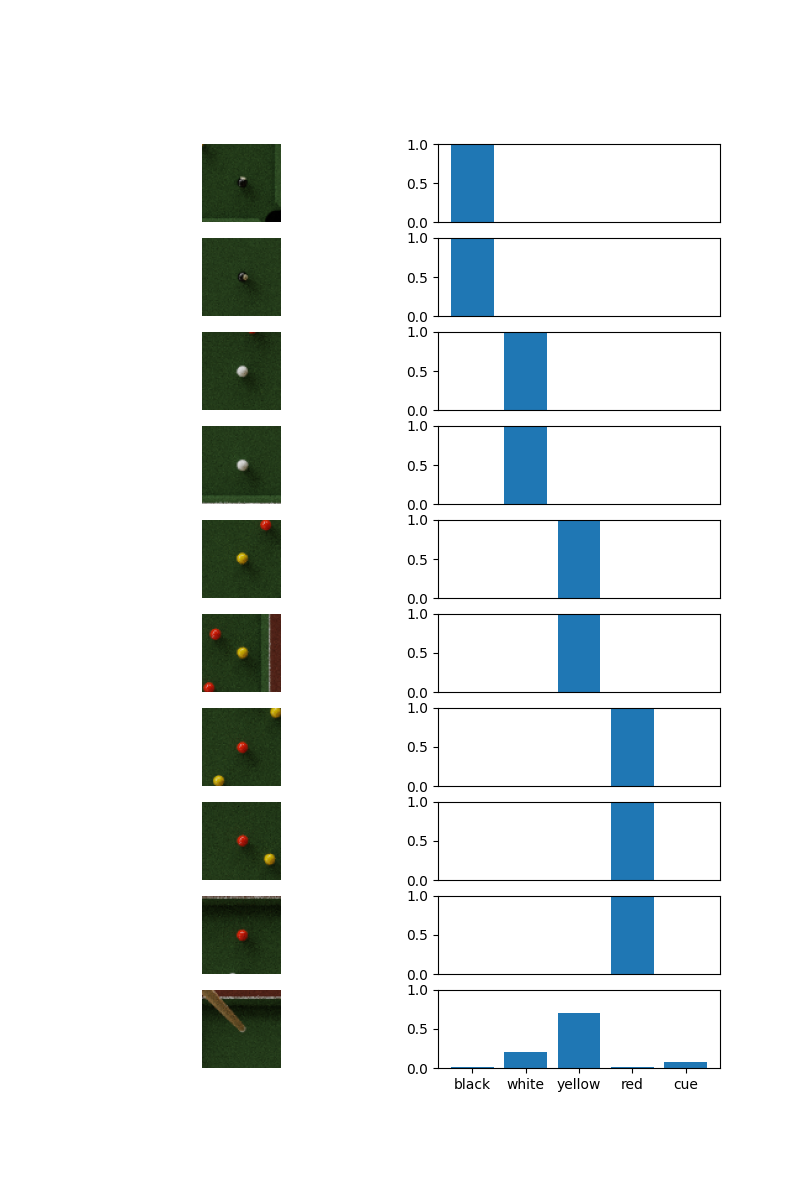

<IPython.core.display.Javascript object>


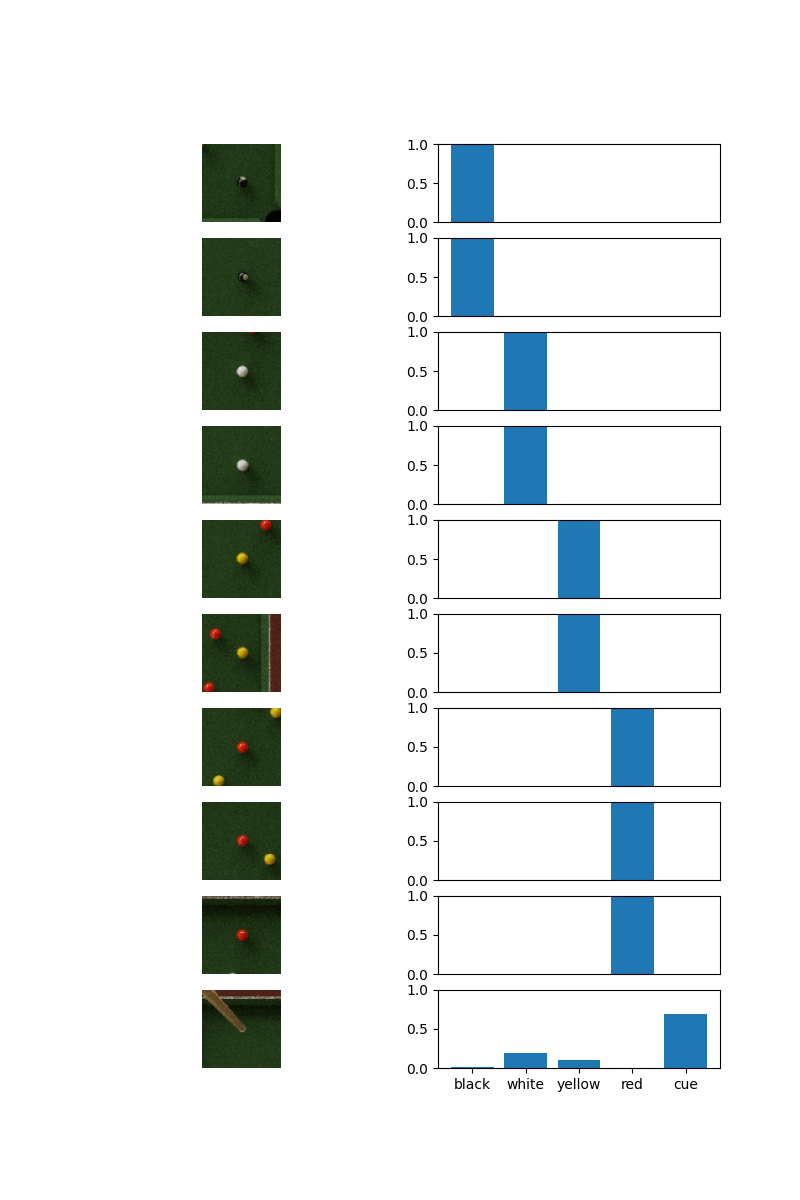

<IPython.core.display.Javascript object>


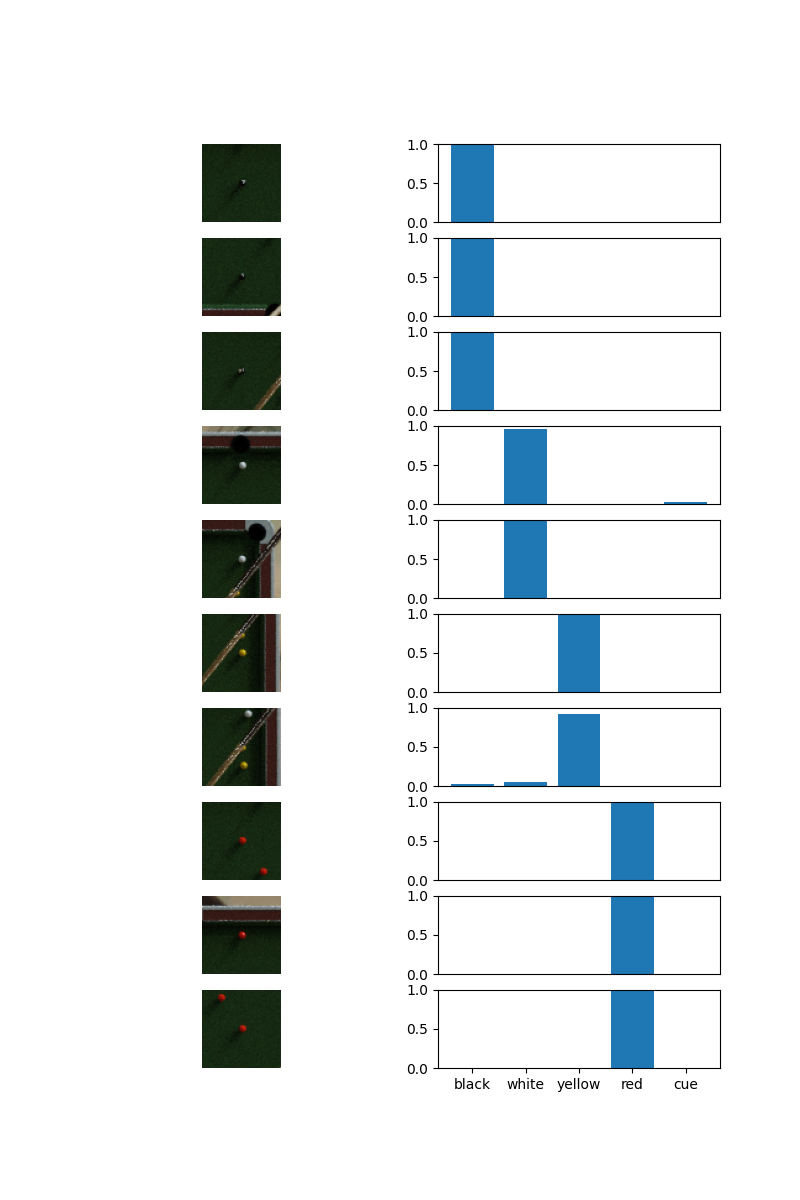

<IPython.core.display.Javascript object>


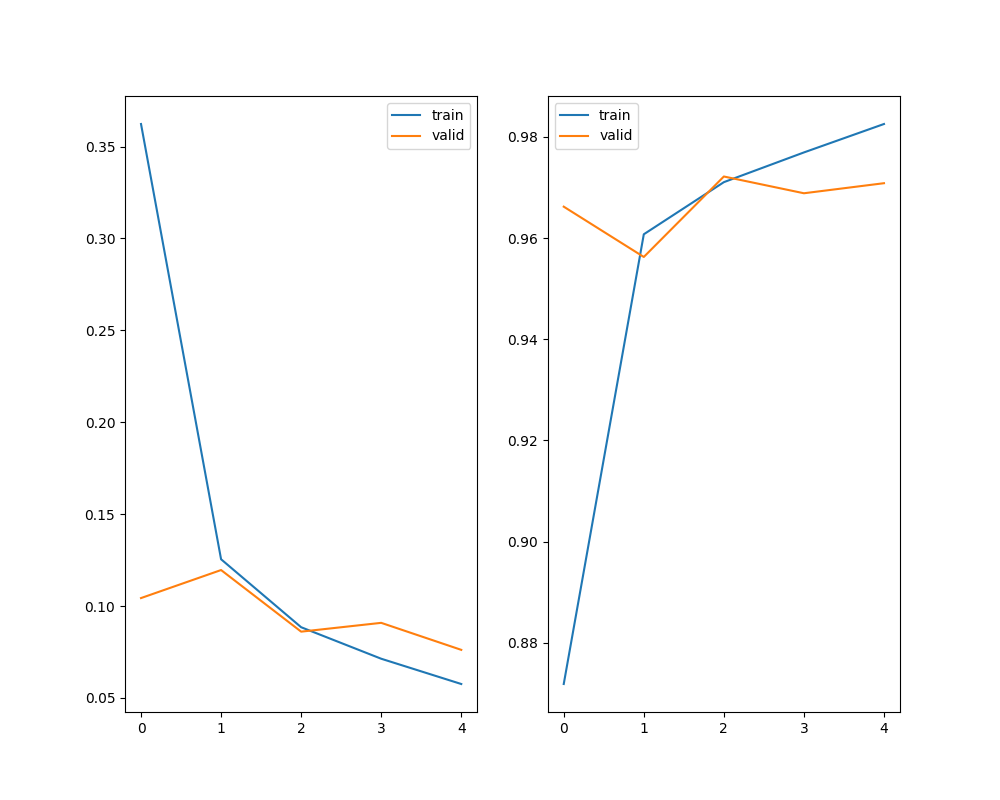

In [5]:
EPOCHS = 5

history_loss = {"train": [], "valid": []}
history_acc  = {"train": [], "valid": []}
for epoch in tqdm(range(EPOCHS), desc="Epoch"):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    pbar = tqdm(train_loader, "Train")
    for window, label in pbar:
        window, label = window.cuda(), label.cuda()
        optim.zero_grad()
        logits = model(window)
        loss = criterion(logits, label)
        acc = (torch.argmax(logits, dim=1) == label).sum()
        loss.backward()
        optim.step()
        total_loss += loss.item()
        total_acc += acc.item()
        pbar.set_postfix(loss=total_loss / len(train_loader), acc=total_acc / len(train))
    history_loss["train"].append(total_loss / len(train_loader))
    history_acc["train"].append(total_acc / len(train))
    
    with torch.no_grad():
        model.eval()
        total_loss, total_acc = 0.0, 0.0
        pbar = tqdm(valid_loader, "Valid")
        for window, label in pbar:
            window, label = window.cuda(), label.cuda()
            logits = model(window)
            loss = criterion(logits, label)
            acc = (torch.argmax(logits, dim=1) == label).sum()
            total_loss += loss.item()
            total_acc += acc.item()
            pbar.set_postfix(loss=total_loss / len(valid_loader), acc=total_acc / len(valid))
        plot_example(f"{epoch:06d}", valid)
    history_loss["valid"].append(total_loss / len(valid_loader))
    history_acc["valid"].append(total_acc / len(valid))
            
with torch.no_grad():
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    pbar = tqdm(test_loader, "Test")
    for window, label in pbar:
        window, label = window.cuda(), label.cuda()
        logits = model(window)
        loss = criterion(logits, label)
        acc = (torch.argmax(logits, dim=1) == label).sum()
        total_loss += loss.item()
        total_acc += acc.item()
        pbar.set_postfix(loss=total_loss / len(test_loader), acc=total_acc / len(test))
    plot_example("test", test)
    
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(1, 2, 1) 
ax.plot(history_loss["train"])
ax.plot(history_loss["valid"])
ax.legend(labels=("train", "valid"))
ax  = fig.add_subplot(1, 2, 2)
ax.plot(history_acc["train"])
ax.plot(history_acc["valid"])
ax.legend(labels=("train", "valid"))
fig.canvas.draw()
fig.savefig("history.png")
fig.show()